In [ ]:
#!pip install pystan
#!pip install prophet

In [4204]:
'''
Prophet is a forecasting procedure implemented in R and Python. 
It is fast and provides completely automated forecasts that can be tuned by hand by data 
Prophet is a powerful tool for predicting future values in time series data, 
especially when your data has repeating patterns like monthly or ..
'''

'\nProphet is a forecasting procedure implemented in R and Python. \nIt is fast and provides completely automated forecasts that can be tuned by hand by data \nProphet is a powerful tool for predicting future values in time series data, \nespecially when your data has repeating patterns like monthly or ..\n'

In [4205]:
from prophet import Prophet
import pandas as pd
from datetime import datetime
import json
import requests
from dotenv import load_dotenv
import base64
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4206]:
''' pip install python-dotenv'''
load_dotenv() # will search for .env file in local folder and load variables 

True

In [4207]:
# 데이터 불러오기
# data = pd.read_csv('example.csv')

In [4208]:
# Split data into train and test sets
# train_size = int(len(df) * 0.8)
# train_data, test_data = df[:train_size], df[train_size:]

In [ ]:
# Get dataset from the Prometheus via query 
# http://localhost:9090/api/v1/query?query=elasticsearch_process_cpu_percent{cluster=test}[1440m]


In [4210]:
''' base64 encode '''
def base64_encode_for_search_guard(id_pass):
    ''' format -> <id>:<password> '''
    encoded = '{}'.format(base64.b64encode(id_pass.encode('utf-8')).decode())
    # print(encoded)
    return encoded

In [4211]:
''' base64 decode '''
def base64_decode_for_search_guard(id_pass):
    ''' format -> <id>:<password> '''
    return base64.b64decode(id_pass).decode('utf-8')

In [4212]:
def get_timestamp_to_date(_timestamp):
    # timestamp is number of seconds since 1970-01-01 
    # _timestamp = 1748444132.405
    
    # convert the timestamp to a datetime object in the local timezone
    dt_object = datetime.fromtimestamp(_timestamp)
    
    # print the datetime object and its type
    # print("dt_object =", dt_object)

    return "{}".format(dt_object)

In [4213]:
get_timestamp_to_date(float('1748444142.405'))

'2025-05-28 10:55:42.405000'

In [ ]:
''' Prometheus URL '''
host = "http://localhost:9090"

In [ ]:
key_node1 = "test-1"
key_node2 = "test-2"
key_node3 = "test-3"

In [4216]:
_periods = 3

In [ ]:
def request_to_prometheus(prometheus_query):
    try:
        ''' wxuser '''
        res = requests.get(
            url="{}/api/v1/query".format(host), 
            params=prometheus_query,
            headers=get_headers("test:test"), 
            verify=False)
    
        if not res.status_code == 200:
           print(res.status_code, http_status_code.get(res.status_code, "None"))
           print('\n')
           return
           
        # print(json.dumps(res.json(), indent=2))
        return res.json()
        # print('\n')
    except Exception as e:
        print(str(e))

In [ ]:
query = {
    'query': """
elasticsearch_process_cpu_percent{cluster="%s"}[100h]
""" % ("test")
}

''' http://localhost:9090/api/v1/query?query=basicMemoryInfoGBGauge{server_job=~localhost}'''
resp = request_to_prometheus(query)

In [4219]:
# print(json.dumps(resp, indent=2))

In [4220]:
raw_data_dict = {}

In [4221]:
for metric_json in resp['data']['result']:
    # print(metric_json['metric']['cluster'])
    raw_dataset = {}
    ds_list, y_list = [], []
    
    for element in metric_json['values']:
        ds_list.append(get_timestamp_to_date(float(element[0])))
        y_list.append(int(element[1]))
        
    raw_dataset.update({
        'node' : metric_json['metric']['name'],
        'metcis_name' : metric_json['metric']['__name__'],
        'ds' : ds_list,
        'y' : y_list
    })

    raw_data_dict.update({metric_json['metric']['name'] : raw_dataset})

In [4222]:
# print(json.dumps(raw_data_dict, indent=2))
# print(raw_data_dict)

In [4223]:
# print(json.dumps(raw_data_dict.get(key_name), indent=2))

In [4224]:
# 시계열 데이터 준비
train_df_node1 = pd.DataFrame({
    # 'ds': ['2023-01-01', '2023-01-01', '2023-01-01', '2023-01-04'],
    'ds' : raw_data_dict.get(key_node1)['ds'],
    # 'y': [1, 2, 9, 1]
    'y' : raw_data_dict.get(key_node1)['y'],
    'lower_window': -1,
    'upper_window': 1,
})
# df['ds'] = pd.to_datetime(df['ds'])

In [4225]:
train_df_node2 = pd.DataFrame({
    # 'ds': ['2023-01-01', '2023-01-01', '2023-01-01', '2023-01-04'],
    'ds' : raw_data_dict.get(key_node2)['ds'],
    # 'y': [1, 2, 9, 1]
    'y' : raw_data_dict.get(key_node2)['y'],
    'lower_window': -1,
    'upper_window': 1,
})

In [4226]:
train_df_node3 = pd.DataFrame({
    # 'ds': ['2023-01-01', '2023-01-01', '2023-01-01', '2023-01-04'],
    'ds' : raw_data_dict.get(key_node3)['ds'],
    # 'y': [1, 2, 9, 1]
    'y' : raw_data_dict.get(key_node3)['y'],
    'lower_window': -1,
    'upper_window': 1,
})

In [4227]:
# train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')
# f = train.sort_values('일시')

In [4228]:
# prophet_df = df[ ['Date', 'AveragePrice'] ] # 컬럼 추출
# prophet_df.columns = ['ds', 'y'] # 컬럼명 변경
# prophet_df.head()

In [4229]:
# display(df)

In [4230]:
# https://raniche-note.tistory.com/23

'''
prophet = Prophet(
# trend
growth = 'linear',
changepoints = None,
changepoint_range = 0.9, 
changepoint_prior_scale= 0.9, 
# seasonality
seasonality_prior_scale=10,
weekly_seasonality=False,
yearly_seasonality=False,
daily_seasonality=False,
seasonality_mode='additive',
#holiday
holidays=holidays,
holidays_prior_scale = 0.5,
#interval_width
interval_width = 0.95,
#mcmc
mcmc_samples = 100
)
prophet.add_seasonality(name='monthly',period=30.5,fourier_order=5) 
prophet.fit(train) 
'''

"\nprophet = Prophet(\n# trend\ngrowth = 'linear',\nchangepoints = None,\nchangepoint_range = 0.9, \nchangepoint_prior_scale= 0.9, \n# seasonality\nseasonality_prior_scale=10,\nweekly_seasonality=False,\nyearly_seasonality=False,\ndaily_seasonality=False,\nseasonality_mode='additive',\n#holiday\nholidays=holidays,\nholidays_prior_scale = 0.5,\n#interval_width\ninterval_width = 0.95,\n#mcmc\nmcmc_samples = 100\n)\nprophet.add_seasonality(name='monthly',period=30.5,fourier_order=5) \nprophet.fit(train) \n"

In [4231]:
# 모델 생성 및 학습
# model = Prophet()
# model = Prophet(seasonality_mode='additive')
model_node1 = Prophet(growth="logistic")
train_df_node1['cap'] = 100
train_df_node1['floor'] = 0
model_node1.fit(train_df_node1)

# 미래 데이터프레임 생성
future_node1 = model_node1.make_future_dataframe(periods=_periods, freq = 'D')
future_node1['cap'] = 100
future_node1['floor'] = 0
# future.tail()

15:39:23 - cmdstanpy - INFO - Chain [1] start processing
15:40:02 - cmdstanpy - INFO - Chain [1] done processing


In [4232]:
# 모델 생성 및 학습
# model = Prophet()
# model = Prophet(seasonality_mode='additive')
model_node2 = Prophet(growth="logistic")
train_df_node2['cap'] = 100
train_df_node2['floor'] = 0
model_node2.fit(train_df_node2)

# 미래 데이터프레임 생성
future_node2 = model_node2.make_future_dataframe(periods=_periods, freq = 'D')
future_node2['cap'] = 100
future_node2['floor'] = 0
# future.tail()

15:40:03 - cmdstanpy - INFO - Chain [1] start processing
15:40:25 - cmdstanpy - INFO - Chain [1] done processing


In [4233]:
# 모델 생성 및 학습
# model_node3 = Prophet()
# model_node3 = Prophet(seasonality_mode='additive')
model_node3 = Prophet(growth="logistic")
train_df_node3['cap'] = 100
train_df_node3['floor'] = 0
model_node3.fit(train_df_node3)

# 미래 데이터프레임 생성
future_node3 = model_node3.make_future_dataframe(periods=_periods, freq = 'D')
future_node3['cap'] = 100
future_node3['floor'] = 0
# future.tail()

15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:57 - cmdstanpy - INFO - Chain [1] done processing


In [4234]:
# 예측 수행
forecast_node1 = model_node1.predict(future_node1)
# forecast_node1.head()
forecast_node2 = model_node2.predict(future_node2)
forecast_node3 = model_node2.predict(future_node3)

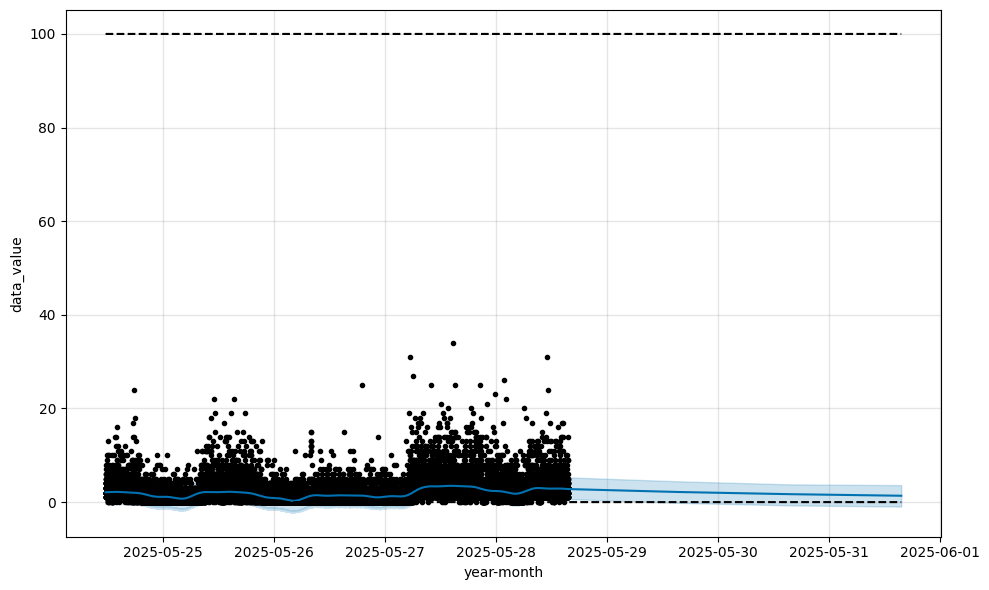

In [4235]:
# 예측 결과 시각화
# fig = model.plot(forecast, figsize=(20,10), xlabel='year-month', ylabel='reward amount')
fig_node1 = model_node1.plot(forecast_node1, xlabel='year-month', ylabel='data_value')

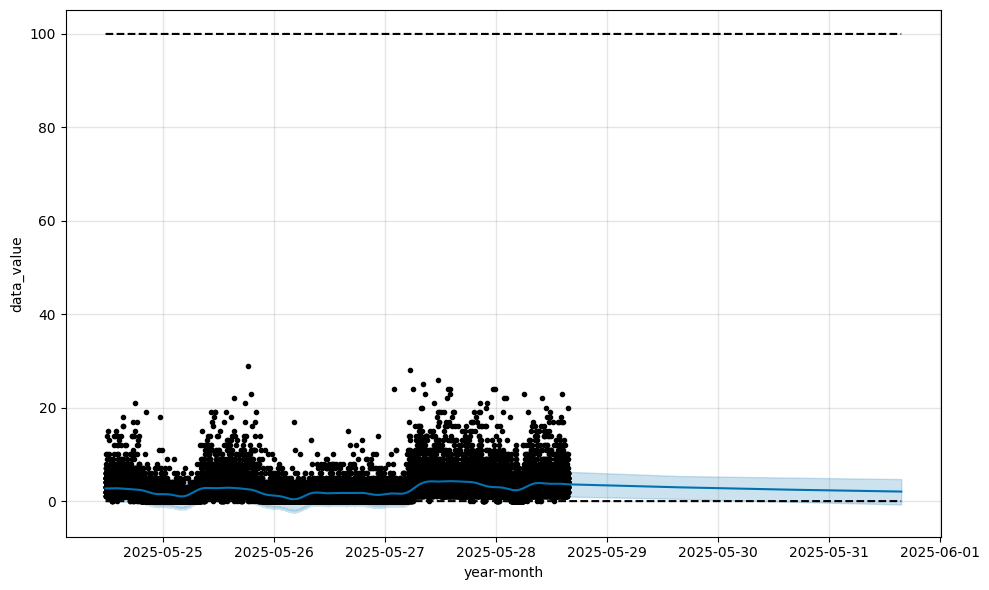

In [4236]:
fig_node2 = model_node2.plot(forecast_node2, xlabel='year-month', ylabel='data_value')

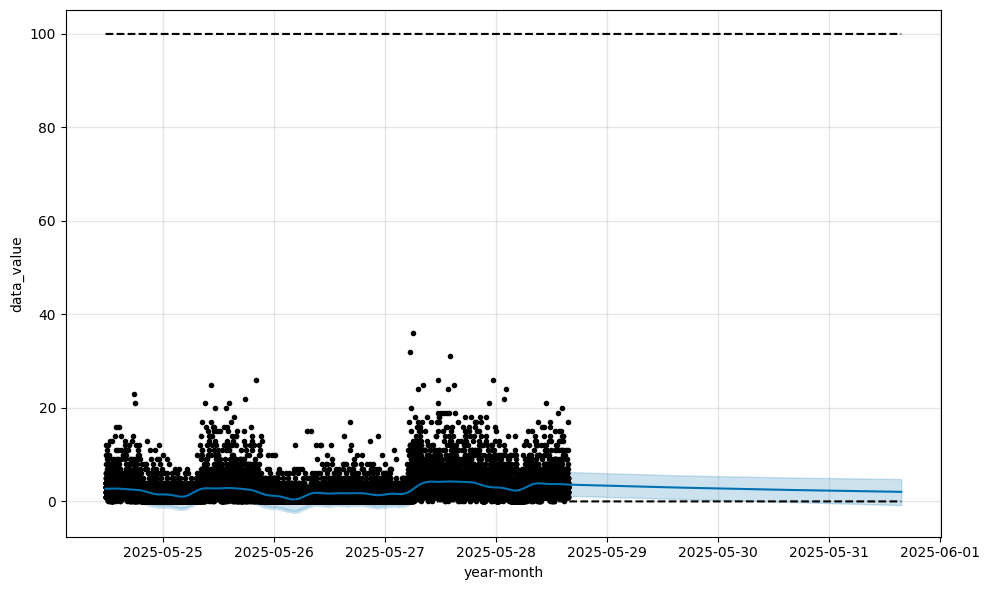

In [4237]:
fig_node3 = model_node3.plot(forecast_node3, xlabel='year-month', ylabel='data_value')

In [4238]:
# fig, ax = plt.subplots(figsize=(16,5))
# model.plot(forecast, ax=ax)
# plt.show()

In [4239]:
# fig2 = model.plot_components(forecast)

In [4240]:
# df.head()

In [4241]:
# forecast.head()

In [4242]:
t = (forecast
    .loc[:, ['ds', 'yhat']]
    # .merge(df)
)

In [4243]:
# plt.scatter(t['ds'], t['y'], s=10)
# plt.scatter(t['ds'], t['yhat'], s=10)

In [4244]:
print("Done..")

Done..
